C:\Users\AmishAnand\AppData\Local\Temp\ipykernel_4260\1529809636.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed


Optimal Portfolio Weights (Highest Sharpe Ratio):
Return                  0.282500
Volatility              0.163096
Sharpe Ratio            1.609481
Weight_BAJFINANCE.NS    0.065494
Weight_BHARTIARTL.NS    0.246116
Weight_HDFCBANK.NS      0.050092
Weight_HINDUNILVR.NS    0.033903
Weight_ICICIBANK.NS     0.121182
Weight_INFY.NS          0.081619
Weight_LT.NS            0.223736
Weight_RELIANCE.NS      0.019004
Weight_SBIN.NS          0.130772
Weight_TCS.NS           0.028081
Name: 15956, dtype: float64

--- Running Standard Parametric Simulation ---
VaR (95% Parametric): ₹-16,835.62
CVaR (95% Parametric): ₹35,142.24
Average Max Drawdown: 9.59%
Worst-Case Max Drawdown (99th percentile): 19.30%


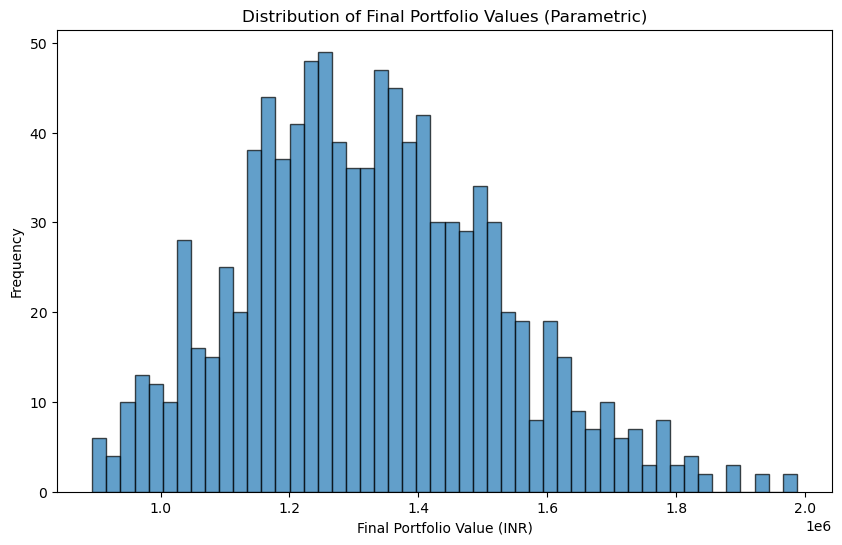


--- Running Historical Bootstrapping Simulation ---
VaR (95% Bootstrapping): ₹-2,432.86
CVaR (95% Bootstrapping): ₹67,345.81
Average Max Drawdown: 10.93%
Worst-Case Max Drawdown (99th percentile): 23.68%


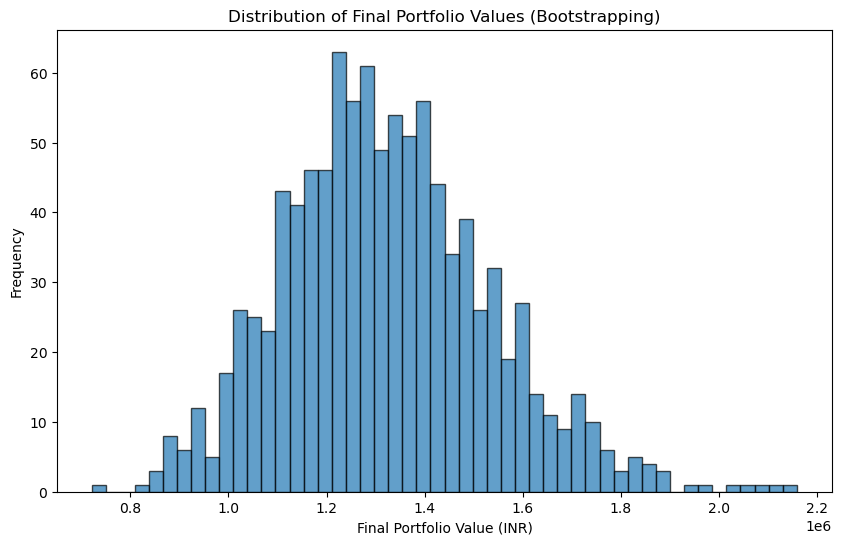


--- Running Stress Test Simulation ---
VaR (95% Stress Test): ₹-30,712.38
CVaR (95% Stress Test): ₹28,329.44
Average Max Drawdown: 9.47%
Worst-Case Max Drawdown (99th percentile): 18.85%


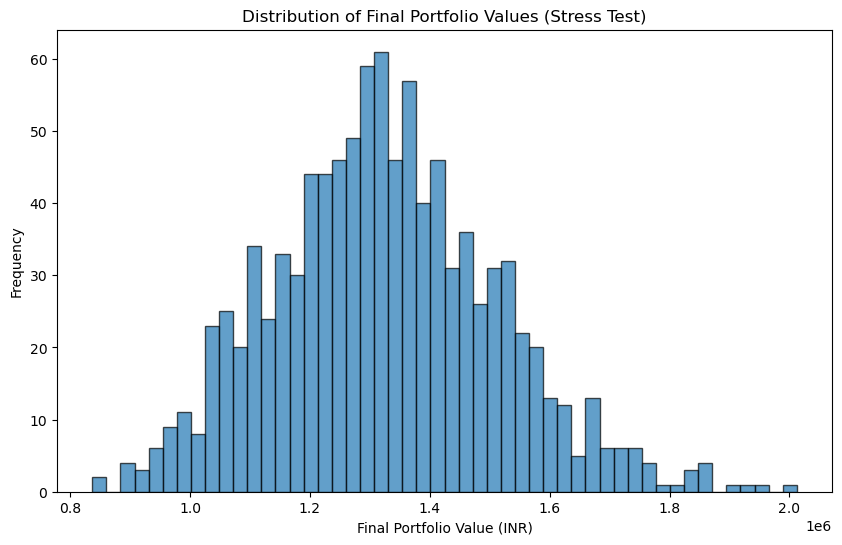

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

# --- 1. Data Acquisition and Preparation ---
def get_data(tickers, start_date, end_date):
    """
    Fetches historical stock data and calculates returns and covariance matrix.
    """
    try:
        stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
        if stock_data.empty:
            raise ValueError("No data returned from yfinance. Check tickers or date range.")
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None, None
        
    returns = stock_data.pct_change().dropna()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return returns, mean_returns, cov_matrix

# Define your Nifty 50 top 10 portfolio and date range
tickers = ['RELIANCE.NS', 'HDFCBANK.NS', 'BHARTIARTL.NS', 'TCS.NS', 'ICICIBANK.NS', 
           'SBIN.NS', 'BAJFINANCE.NS', 'INFY.NS', 'HINDUNILVR.NS', 'LT.NS']
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*5) # 5 years of historical data

historical_returns, mean_returns, cov_matrix = get_data(tickers, start_date, end_date)

if historical_returns is None:
    print("Exiting program due to data error.")
    exit()

# --- 2. Portfolio Optimization (Monte Carlo) ---
def optimize_portfolio(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    """
    Runs a Monte Carlo simulation to find the optimal portfolio with the highest Sharpe Ratio.
    """
    results = np.zeros((len(mean_returns)+3, num_portfolios))
    
    for i in range(num_portfolios):
        weights = np.array(np.random.random(len(mean_returns)))
        weights /= np.sum(weights)
        
        portfolio_return = np.sum(mean_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
        
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = sharpe_ratio
        for j in range(len(weights)):
            results[j+3, i] = weights[j]

    columns = ['Return', 'Volatility', 'Sharpe Ratio'] + [f'Weight_{t}' for t in mean_returns.index]
    results_df = pd.DataFrame(results.T, columns=columns)
    max_sharpe_portfolio = results_df.loc[results_df['Sharpe Ratio'].idxmax()]
    
    return results_df, max_sharpe_portfolio

num_portfolios = 20000
risk_free_rate = 0.02 
results_df, max_sharpe_portfolio = optimize_portfolio(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

print("Optimal Portfolio Weights (Highest Sharpe Ratio):")
print(max_sharpe_portfolio)

# --- 3. Run Simulation with Optimal Weights and Get All Metrics ---
def get_all_metrics(returns_data, weights, num_simulations, time_horizon, initial_value, method='parametric'):
    """
    Runs the Monte Carlo simulation and calculates a full suite of metrics.
    Method can be 'parametric' or 'bootstrapping'.
    """
    if method == 'parametric':
        mean_returns = returns_data.mean()
        cov_matrix = returns_data.cov()
        chol_decomp = np.linalg.cholesky(cov_matrix)
        daily_returns_sim = np.zeros((time_horizon, len(weights), num_simulations))
        for s in range(num_simulations):
            random_variables = np.random.normal(size=(time_horizon, len(weights)))
            correlated_returns = np.dot(random_variables, chol_decomp)
            daily_returns_sim[:, :, s] = correlated_returns + mean_returns.values
    
    elif method == 'bootstrapping':
        daily_returns_sim = np.zeros((time_horizon, len(weights), num_simulations))
        for s in range(num_simulations):
            # Sample historical returns with replacement
            indices = np.random.choice(returns_data.index, size=time_horizon, replace=True)
            daily_returns_sim[:, :, s] = returns_data.loc[indices].values
    
    portfolio_values = np.zeros((time_horizon + 1, num_simulations))
    portfolio_values[0, :] = initial_value
    max_drawdowns = np.zeros(num_simulations)

    for s in range(num_simulations):
        daily_portfolio_returns = np.dot(daily_returns_sim[:, :, s], weights)
        portfolio_growth = np.cumprod(1 + daily_portfolio_returns)
        portfolio_values[1:, s] = initial_value * portfolio_growth
        
        # Calculate max drawdown for this path
        peak_value = 0
        max_dd = 0
        for val in portfolio_values[1:, s]:
            if val > peak_value:
                peak_value = val
            dd = (peak_value - val) / peak_value
            if dd > max_dd:
                max_dd = dd
        max_drawdowns[s] = max_dd

    final_values = portfolio_values[-1, :]
    confidence_level = 0.95
    var_95 = np.percentile(final_values, 100 * (1 - confidence_level))
    var_loss_95 = initial_value - var_95
    cvar_values = final_values[final_values <= var_95]
    cvar_loss = initial_value - np.mean(cvar_values)

    return portfolio_values, final_values, var_loss_95, cvar_loss, max_drawdowns

# --- 4. Main Execution and Visualization ---
initial_portfolio_value = 1000000 
time_horizon = 252 # 1 year
num_simulations = 1000

optimal_weights = max_sharpe_portfolio.iloc[3:].values

# Scenario 1: Standard Monte Carlo with Parametric Returns
print("\n--- Running Standard Parametric Simulation ---")
port_vals_p, final_vals_p, var_loss_p, cvar_loss_p, max_dds_p = get_all_metrics(
    historical_returns, optimal_weights, num_simulations, time_horizon, initial_portfolio_value, method='parametric')

print(f"VaR (95% Parametric): ₹{var_loss_p:,.2f}")
print(f"CVaR (95% Parametric): ₹{cvar_loss_p:,.2f}")
print(f"Average Max Drawdown: {np.mean(max_dds_p)*100:.2f}%")
print(f"Worst-Case Max Drawdown (99th percentile): {np.percentile(max_dds_p, 99)*100:.2f}%")

# Plotting final distribution
plt.figure(figsize=(10, 6))
plt.hist(final_vals_p, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Portfolio Values (Parametric)')
plt.xlabel('Final Portfolio Value (INR)')
plt.ylabel('Frequency')
plt.show()

# Scenario 2: Historical Bootstrapping
print("\n--- Running Historical Bootstrapping Simulation ---")
port_vals_b, final_vals_b, var_loss_b, cvar_loss_b, max_dds_b = get_all_metrics(
    historical_returns, optimal_weights, num_simulations, time_horizon, initial_portfolio_value, method='bootstrapping')

print(f"VaR (95% Bootstrapping): ₹{var_loss_b:,.2f}")
print(f"CVaR (95% Bootstrapping): ₹{cvar_loss_b:,.2f}")
print(f"Average Max Drawdown: {np.mean(max_dds_b)*100:.2f}%")
print(f"Worst-Case Max Drawdown (99th percentile): {np.percentile(max_dds_b, 99)*100:.2f}%")

# Plotting final distribution
plt.figure(figsize=(10, 6))
plt.hist(final_vals_b, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Portfolio Values (Bootstrapping)')
plt.xlabel('Final Portfolio Value (INR)')
plt.ylabel('Frequency')
plt.show()

# Scenario 3: Stress Testing (Manual Shock)
print("\n--- Running Stress Test Simulation ---")
# Define a market shock where returns drop by 30% over 1 month
stress_returns = historical_returns.copy()
stress_date_range = stress_returns.index[-21:] # Last 21 trading days
stress_returns.loc[stress_date_range] = stress_returns.loc[stress_date_range] * 0.7 

port_vals_s, final_vals_s, var_loss_s, cvar_loss_s, max_dds_s = get_all_metrics(
    stress_returns, optimal_weights, num_simulations, time_horizon, initial_portfolio_value, method='parametric')

print(f"VaR (95% Stress Test): ₹{var_loss_s:,.2f}")
print(f"CVaR (95% Stress Test): ₹{cvar_loss_s:,.2f}")
print(f"Average Max Drawdown: {np.mean(max_dds_s)*100:.2f}%")
print(f"Worst-Case Max Drawdown (99th percentile): {np.percentile(max_dds_s, 99)*100:.2f}%")

# Plotting final distribution
plt.figure(figsize=(10, 6))
plt.hist(final_vals_s, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Portfolio Values (Stress Test)')
plt.xlabel('Final Portfolio Value (INR)')
plt.ylabel('Frequency')
plt.show()

